[Collab link](https://colab.research.google.com/drive/19sNRhVj6rqKQKaKTvhd5AMKZfVy6OSeI#scrollTo=BVqy3EPwfHwB)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns


Data preprocessing

In [ ]:
df = pd.read_csv("fmcg.csv")

print(df.head())

# Pra-pemrosesan data dengan label encoding dan standarisasi
le = preprocessing.LabelEncoder()

date_col = ['ProcuredDate','OrderDate','ShipDate','DeliveryDate']

def parse_date(date_str):
    formats = ['%d/%m/%y', '%d/%m/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if none of the formats match
for col in date_col:
    df[col] = df[col].apply(parse_date)


df['Delivery_time'] = (df['DeliveryDate'] - df['OrderDate']).dt.days
df['Unit Cost'] = pd.to_numeric(df['Unit Cost'].str.replace('$', '').str.replace(',', ''))
df['Unit Price'] = pd.to_numeric(df['Unit Price'].str.replace('$', '').str.replace(',', ''))

   OrderNumber Sales Channel WarehouseCode ProcuredDate OrderDate  ShipDate  \
0  SO - 000101      In-Store  WARE-UHY1004     31/12/17   31/5/18   14/6/18   
1  SO - 000102        Online  WARE-NMK1003     31/12/17   31/5/18   22/6/18   
2  SO - 000103   Distributor  WARE-UHY1004     31/12/17   31/5/18   21/6/18   
3  SO - 000104     Wholesale  WARE-NMK1003     31/12/17   31/5/18  2/6/2018   
4  SO - 000105   Distributor  WARE-NMK1003    10/4/2018   31/5/18   16/6/18   

  DeliveryDate CurrencyCode  _SalesTeamID  _CustomerID  _StoreID  _ProductID  \
0      19/6/18          USD             6           15       259          12   
1     2/7/2018          USD            14           20       196          27   
2     1/7/2018          USD            21           16       213          16   
3     7/6/2018          USD            28           48       107          23   
4      26/6/18          USD            22           49       111          26   

   Order Quantity  Discount Applied  Unit Co

Data visualization

<ipython-input-23-dec7cb05eb98>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sales Channel', data=df, palette='viridis')


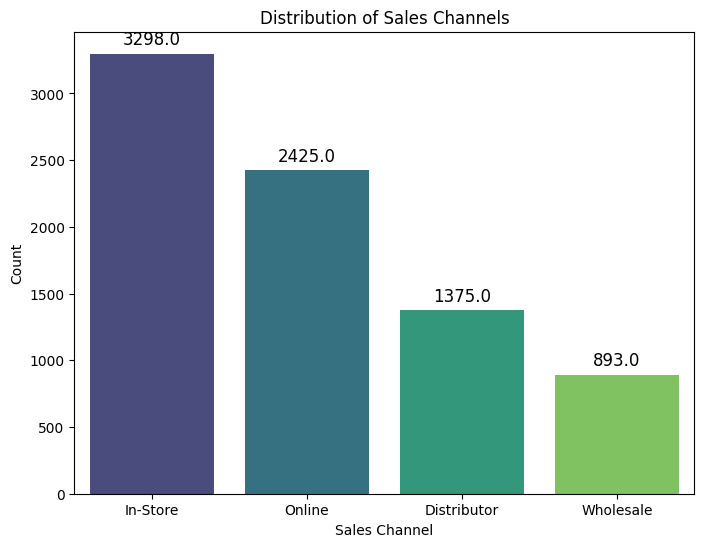

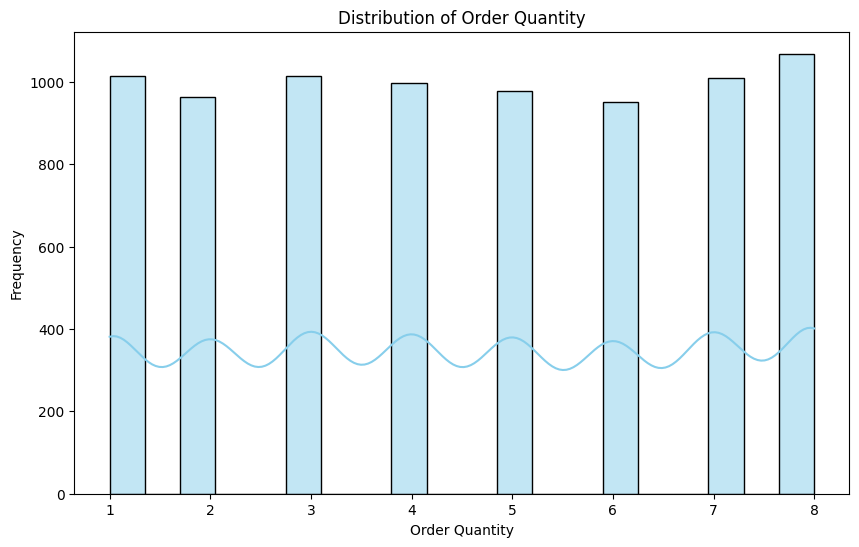

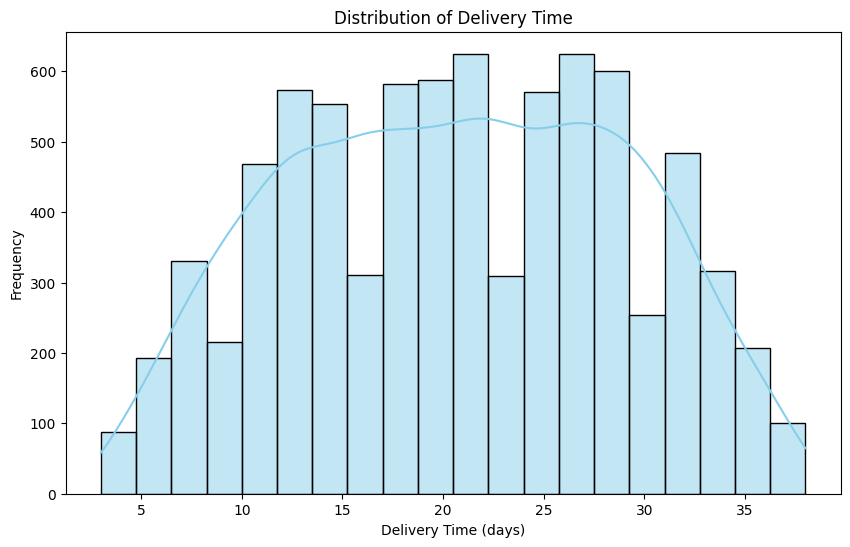

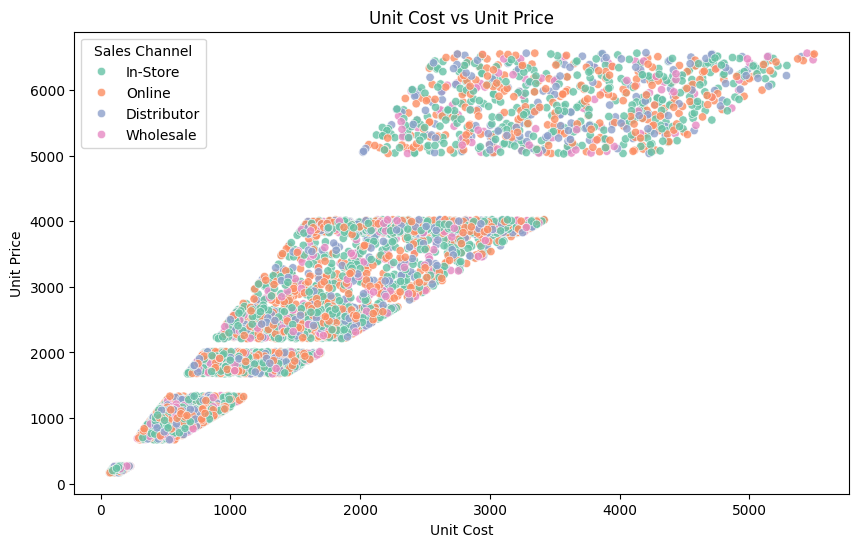

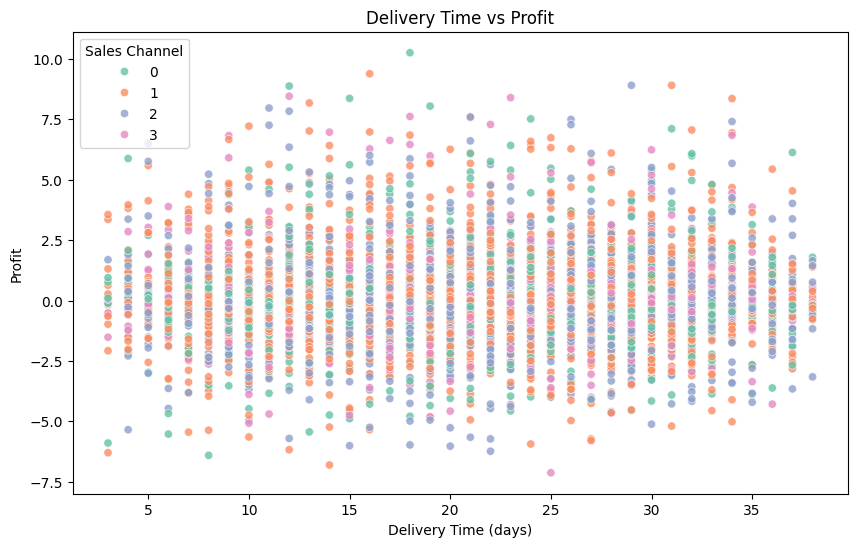

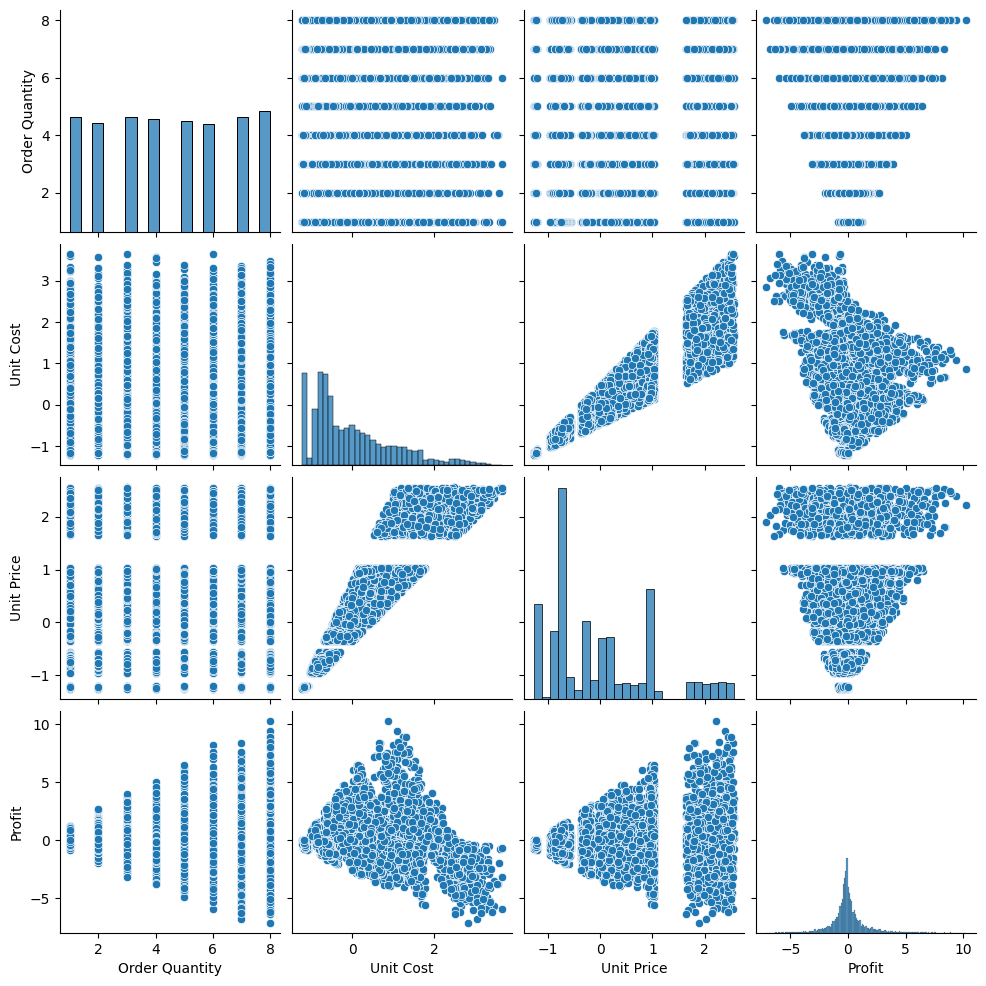

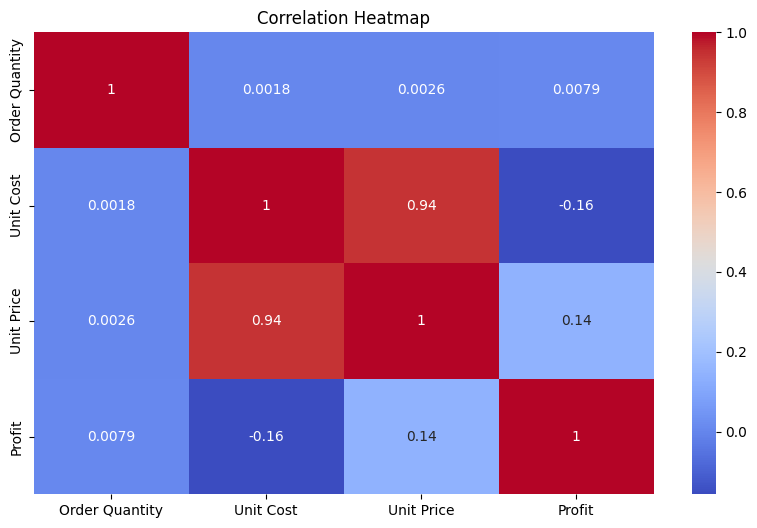

In [ ]:

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Sales Channel', data=df, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.xlabel('Sales Channel')
plt.ylabel('Count')
plt.title('Distribution of Sales Channels')
plt.show()

# Distribution of 'Order Quantity'
plt.figure(figsize=(10, 6))
sns.histplot(df['Order Quantity'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Order Quantity')
plt.xlabel('Order Quantity')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'Delivery_time'
plt.figure(figsize=(10, 6))
sns.histplot(df['Delivery_time'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of 'Unit Cost' vs 'Unit Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Unit Cost', y='Unit Price', data=df, hue='Sales Channel', palette='Set2', alpha=0.8)
plt.title('Unit Cost vs Unit Price')
plt.xlabel('Unit Cost')
plt.ylabel('Unit Price')
plt.show()



scaler = StandardScaler()
df[['Unit Cost', 'Unit Price']] = scaler.fit_transform(df[['Unit Cost', 'Unit Price']])

df['Profit']=round((df['Unit Price']-df['Unit Cost'])*df['Order Quantity']*(1-df['Discount Applied']),2)
df.head()

df=df.drop(['OrderNumber','ProcuredDate','OrderDate','ShipDate','DeliveryDate','CurrencyCode'],axis=1)

# Pisahkan fitur dan target
X = df.drop(['Profit'], axis=1)
y = df['Profit']

df['Sales Channel'] = le.fit_transform(df['Sales Channel'])
df['WarehouseCode'] = le.fit_transform(df['WarehouseCode'])


X = df.drop(['Profit'], axis=1)
y = df['Profit']

# Scatter plot of 'Delivery_time' vs 'Profit'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Delivery_time', y='Profit', data=df, hue='Sales Channel', palette='Set2', alpha=0.8)
plt.title('Delivery Time vs Profit')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Profit')
plt.show()

# Pairplot for numeric columns
sns.pairplot(df[['Order Quantity', 'Unit Cost', 'Unit Price', 'Profit']])
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Order Quantity', 'Unit Cost', 'Unit Price', 'Profit']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



Prediction for the profit & order quantity

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 7191, number of used features: 11
[LightGBM] [Info] Start training from score -0.000848
Average Predicted Profit: 0.012580231778571184
R2 score: 0.9856750369232214


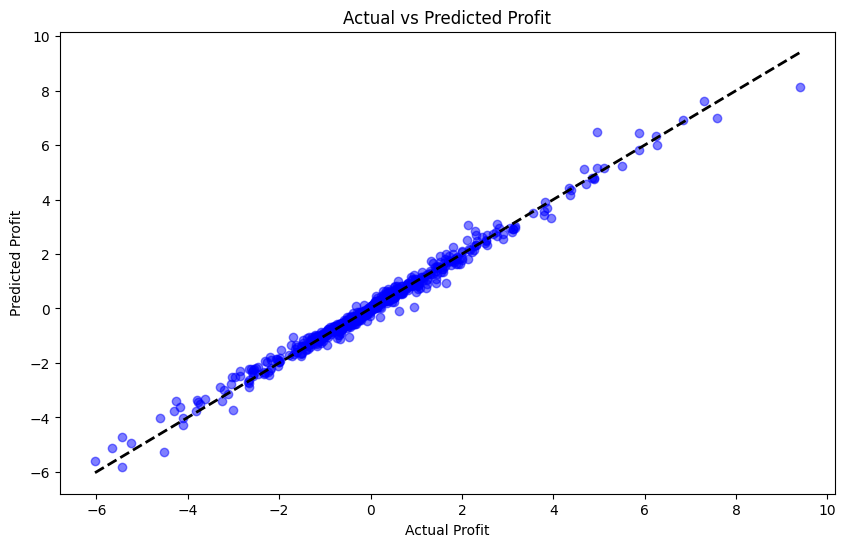

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 7191, number of used features: 11
[LightGBM] [Info] Start training from score 4.520790
Average Predicted Stock: 4.586017126230018
RMSE for Stock Prediction: 1.2021784571086378


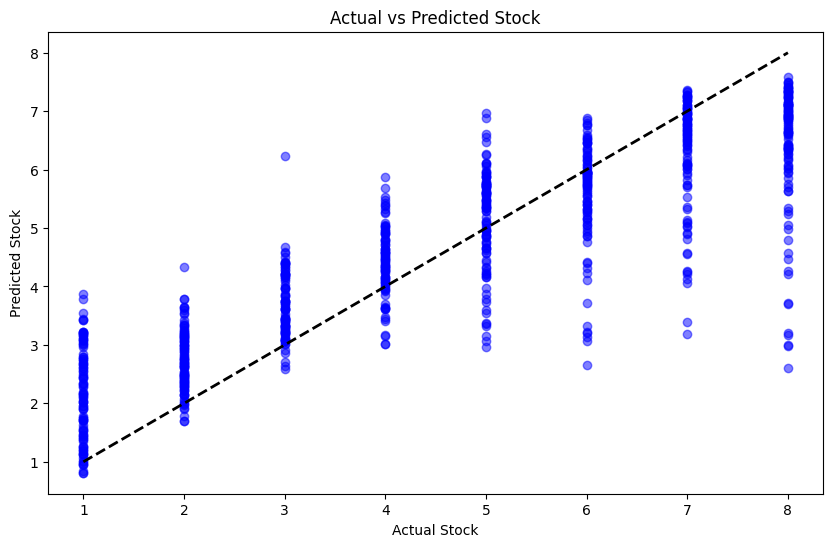

In [ ]:
from sklearn.metrics import mean_squared_error

# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

# Inisialisasi dan latih model LGBMRegressor
lgb_model = LGBMRegressor(n_jobs=-1, random_state=123)
lgb_model.fit(X_train, y_train)

# Lakukan prediksi
y_pred = lgb_model.predict(X_test)

# Evaluasi model menggunakan R-squared
r2 = r2_score(y_test, y_pred)
average_predicted_profit = np.mean(y_pred)
print(f"Average Predicted Profit: {average_predicted_profit}")
print(f"R2 score: {r2}")

# Visualize the model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit')
plt.show()

# Adjust target variable to 'Order Quantity' for stock prediction
y_stock = df['Order Quantity']

# Adjust features and drop unnecessary columns
X_stock = df.drop(['Order Quantity'], axis=1)

# Train/Test Split for Stock Prediction
X_train_stock, X_test_stock, y_train_stock, y_test_stock = train_test_split(X_stock, y_stock, train_size=0.9, random_state=42)

# Initialize and train stock prediction model
lgb_stock_model = LGBMRegressor(n_jobs=-1, random_state=123)
lgb_stock_model.fit(X_train_stock, y_train_stock)

# Predict stock
stock_pred = lgb_stock_model.predict(X_test_stock)

# Evaluate stock prediction model using RMSE
rmse_stock = np.sqrt(mean_squared_error(y_test_stock, stock_pred))
average_predicted_stock = np.mean(stock_pred)
print(f"Average Predicted Stock: {average_predicted_stock}")
print(f"RMSE for Stock Prediction: {rmse_stock}")

# Visualize stock prediction model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_stock, stock_pred, color='blue', alpha=0.5)
plt.plot([y_test_stock.min(), y_test_stock.max()], [y_test_stock.min(), y_test_stock.max()], 'k--', lw=2)
plt.xlabel('Actual Stock')
plt.ylabel('Predicted Stock')
plt.title('Actual vs Predicted Stock')
plt.show()